In [1]:
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import json

from skbio import OrdinationResults
from biom import load_table
from matplotlib_venn import (venn2, venn2_unweighted)

# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

## Define functions

In [2]:
def get_top_features(table, ordination, component='PC1', 
                     quantile=0.90, pseudocount=0):
    
    #get the loadings
    floadings = ordination.copy()
    floadings.rename(columns={0:"PC1", 1:"PC2", 
                              2:"PC3", 3:"PC4"}, inplace=True)
    table_df = table.copy().to_dataframe()
    top_pc_values = {}
    bottom_pc_values = {}
    beta_l = {}
    
    #sort loadings along each component
    floadings.sort_values(by=component, ascending=False, inplace=True)
    floadings_ = floadings[component].copy()
    #get top and bottom loading quantiles
    top_q = floadings_.quantile(quantile)
    bottom_q = floadings_.quantile(1-quantile)
    top_fts = floadings_[floadings_ >= top_q].index
    bottom_fts = floadings_[floadings_ <= bottom_q].index
    #aggregate the top and bottom features per sample
    num = table_df.loc[top_fts].sum(axis=0)
    num = num+pseudocount
    top_pc_values[component] = num
    
    denom = table_df.loc[bottom_fts].sum(axis=0)
    denom = denom+pseudocount
    bottom_pc_values[component] = denom
    #calculate trajectories
    beta_ = np.log(num) - np.log(denom)
    beta_l[component] = beta_

    #save top and bottom aggregated features as df
    top_fts_df = pd.DataFrame(top_pc_values, index=num.index)
    bottom_fts_df = pd.DataFrame(bottom_pc_values, index=denom.index)
    #save trajectories as df
    beta_df = pd.DataFrame(beta_l, index=num.index)
    #drop any NaN or infinity values
    beta_df = beta_df.sparse.to_dense()
    beta_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    beta_df.dropna(inplace=True)

    return (top_fts_df, bottom_fts_df, beta_df,
            top_fts.tolist(), bottom_fts.tolist())

In [3]:
def rename_feats(features_to_use, taxonomy_18s_nosp,
                 taxonomy_mag, metab_ids, tables):
    
    index_dict = {'metabolite': [], 
                  'mag': [], 
                  '18S': [], 
                  'gene_module': [],
                  'metabolomics': []}
    modality_map = {}

    for ind_ in features_to_use:
        if ind_ in taxonomy_18s_nosp.index:
            label_ = taxonomy_18s_nosp.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['18S'].append((ind_, label_))
            modality_map[label_] = 'Eukaryotes (18S)'

        elif ind_ in taxonomy_mag.index:
            label_ = taxonomy_mag.loc[ind_, :].dropna()
            label_ = label_.values[-1] + ' (' + label_.index[-1] + ')'
            index_dict['mag'].append((ind_, label_))
            modality_map[label_] = 'Bacterial Genomes (MetaG)'
            
        elif ind_ in metab_ids.index:
            label_ = metab_ids.loc[ind_, 'most specific class']
            index_dict['metabolite'].append((ind_, label_))
            modality_map[label_] = 'Metabolites'
            
        else:
            if ind_ in tables['mag'].ids('observation'):
                index_dict['mag'].append((ind_, ind_))
                modality_map[ind_] = 'Bacterial Genomes (MetaG)'
            elif ind_ in tables['18S'].ids('observation'):
                index_dict['18S'].append((ind_, ind_))
                modality_map[ind_] = 'Eukaryotes (18S)'
            elif ind_ in tables['gene_module'].ids('observation'):
                index_dict['gene_module'].append((ind_, ind_))
                modality_map[ind_] = 'Functions (MetaG)'
            elif ind_ in tables['metabolomics'].ids('observation'):
                index_dict['metabolomics'].append((ind_, ind_))
                modality_map[ind_] = 'Metabolites'

    #clean lists in index_dict
    for modality, feature in index_dict.items():
        #clean_lst = ['drop' if len(str(i_)) == 0 else i_ for i_ in feature]
        #clean_lst = ['drop' if str(i_) == 'nan' else i_ for i_ in clean_lst]
        clean_lst = [(i_[0], i_[1].replace('_',' ')) for i_ in feature]
        #drop features
        index_dict[modality] = [i_ for i_ in clean_lst if i_ != 'drop']

    return index_dict

## Load data

In [7]:
# #load rpca results
nPCs = 4
# ord_18S = OrdinationResults.read('../results/joint-rpca/Ordinations/18S_ord_{}PCs.txt'.format(nPCs))
# ord_mag = OrdinationResults.read('../results/joint-rpca/Ordinations/mag_ord_{}PCs.txt'.format(nPCs))
# ord_gene = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_ord_{}PCs.txt'.format(nPCs))
# ord_gene_module = OrdinationResults.read('../results/joint-rpca/Ordinations/gene_module_ord_{}PCs.txt'.format(nPCs))
# ord_metabolite = OrdinationResults.read('../results/joint-rpca/Ordinations/metabolite_ord_{}PCs.txt'.format(nPCs))
#load joint-rpca results
ord_joint = OrdinationResults.read('../results/joint-rpca/Ordinations/joint_ord_{}PCs.txt'.format(nPCs))
#load shared metadata
#metadata = pd.read_csv('../network/split-matched-data/metadata_knn.tsv', index_col=0, sep='\t')

In [4]:
# import the rest
all_tables = {'18S':'../network/split-matched-data/18S.biom',
              'mag':'../network/split-matched-data/mag.biom',
              'gene':'../network/split-matched-data/gene.biom',
              'gene_module':'../network/split-matched-data/gene_module.biom',
              'metabolite':'../network/split-matched-data/metabolite.biom',
              'metabolomics':'../network/split-matched-data/metabolomics.biom'}

tables = {}
for tbl_id, tbl_path in all_tables.items():
    tables[tbl_id] = load_table(tbl_path)

In [5]:
# annots for tables
taxonomy_18s = pd.read_csv('../network/annotations/18S_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_18s = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_18s.index, taxonomy_18s.Taxon.values)}
taxonomy_18s = pd.DataFrame(taxonomy_18s).T
taxonomy_18s_nosp = taxonomy_18s.drop([' s'], axis=1)

taxonomy_mag = pd.read_csv('../network/annotations/MAG_taxonomy.tsv', sep='\t', index_col=0)
taxonomy_mag = {k:{z.split('__')[0]:z.split('__')[-1]
               for z in x.split(';')} for k, x in zip(taxonomy_mag.index, taxonomy_mag.Taxon.values)}
taxonomy_mag = pd.DataFrame(taxonomy_mag).T
taxonomy_mag[taxonomy_mag == ''] = np.nan

metab_ids = pd.read_excel('../network/metabolite_formulas.xlsx', index_col=0)
metab_ids.index = ['metab_' + str(x) for x in metab_ids.index]
metab_ids_class = metab_ids.dropna(subset=['most specific class'])

In [6]:
bt_tmp = tables['metabolite']
keep_metab = set(metab_ids_class.index) & set(bt_tmp.ids('observation'))
bt_tmp = bt_tmp.filter(keep_metab, axis='observation')
#df_tmp = df_tmp.loc[list(keep_metab), :]
#ord_tmp = ord_tmp.loc[list(keep_metab), :].sort_values(by=axis_use)
tables['metabolite'] = bt_tmp
#tables['metabolite'] = [bt_tmp, df_tmp, ord_tmp]

In [8]:
#retrieve feature loadings from joint-rpca
joint_features = ord_joint.features

#for 18S, need to make sure features are in the original table
not_in_ord_18S = []
in_ord_18S = []

for id in tables['18S'].ids(axis='observation'):
    if id not in joint_features.index:
        not_in_ord_18S.append(id)
    else:
        in_ord_18S.append(id)
print("Not in ordination results: %i" % len(not_in_ord_18S))
print("In ordination results: %i" % len(in_ord_18S))

#keep only common features
tables['18S'] = tables['18S'].filter(ids_to_keep=in_ord_18S, axis='observation')

Not in ordination results: 42
In ordination results: 5431


## RPCA and Joint-RPCA
Top 20 and bottom 20 features

In [9]:
#load json files
#with open('../results/joint-rpca/Original/joint_decomposer_feats_test.json', 'r') as f:
with open('../results/joint-rpca/Ordinations/joint_decomposer_feats_test.json', 'r') as f:
    joint_feats = json.load(f)

#with open('../results/joint-rpca/Original/rpca_decomposer_feats_test.json', 'r') as f:
with open('../results/joint-rpca/Ordinations/rpca_decomposer_feats_test.json', 'r') as f:
    rpca_feats = json.load(f)

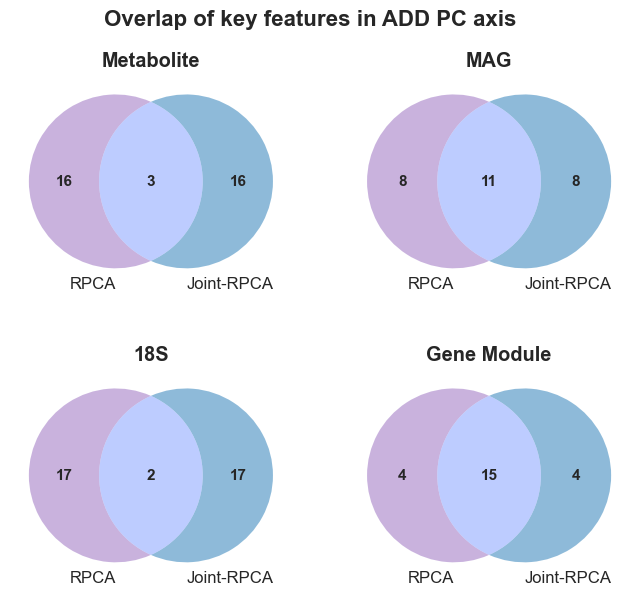

Overlapping features:
{'metabolite': {'metab_540', 'metab_150', 'metab_443'}, 'mag': {'UTK.bins.19', 'SHSU.bins.319', 'SHSU.bins.175', 'UTK.bins.50', 'SHSU_advanced.final.35', 'CMU.bins.248', 'CMU.bins.224', 'UTK.bins.71', 'CMU_advanced.final.11', 'UTK_active.final.26', 'SHSU.bins.42'}, '18S': {'b7493926527a25494179aa6f25f088b5', '32794c9125af0f00b2f95ce56025c220'}, 'gene_module': {'Na_-transporting_0DH:ubiquinone_oxidoreductase-', 'Adhesin_protein_transport_system', 'Trehalose_transport_system', 'Fluoroquinolone_transport_system', 'Universal_Cas_proteins', 'RNF_complex', '0DH:ubiquinone_oxidoreductase_mitochondria', 'D0_polymerase_II_complex_archaea', 'Putrescine_transport_system', 'R0_polymerase_archaea', 'Arginine/ornithine_transport_system', 'D-Methionine_transport_system', 'Tyrosine_biosynthesis_prephanate_to_pretyrosine_to_tyrosine', 'Taurine_transport_system', 'Type_I_signiture_cas_proteins'}}


In [10]:
#plot a venn diagram per omic
omic_title = {'18S': '18S', 'mag': 'MAG', 
              'gene_module': 'Gene Module', 'metabolite': 'Metabolite'}
overlap_feats_omic = {}
rpca_only_feats = {}
joint_only_feats = {}
#define direction for each omic
#e.g. num features = advanced, denom features = initial 
direction = {'metabolite': 0, 'mag': 0,
             '18S': 1, 'gene_module': 1}

#RPCA
fig, axn = plt.subplots(2, 2, figsize=(8, 7))

for ax_, omic_id in zip(axn.flatten(), joint_feats.keys()):
    
   ##check overlap between
   rpca_dir = direction[omic_id]
   rpca_feats_all = rpca_feats[omic_id][rpca_dir]
   joint_feats_all = joint_feats[omic_id][0]

   #find overlap
   overlap_feats = set(rpca_feats_all).intersection(set(joint_feats_all))
   overlap_feats_omic[omic_id] = overlap_feats

   #find unique features
   rpca_only = set(rpca_feats_all) - set(joint_feats_all)
   joint_only = set(joint_feats_all) - set(rpca_feats_all)
   rpca_only_feats[omic_id] = rpca_only
   joint_only_feats[omic_id] = joint_only

   #plot venn diagram                  
   a = len(rpca_feats_all) - len(overlap_feats)
   b = len(overlap_feats)
   c = len(joint_feats_all) - len(overlap_feats)

   v = venn2_unweighted(subsets=(a, c, b), set_labels=('RPCA', 'Joint-RPCA'), ax=ax_,
                        set_colors=('tab:purple', 'tab:blue'), alpha=0.5)
   
   for text in v.set_labels:
      text.set_fontsize(12)
      #text.set_fontweight('bold')
   
   for text in v.subset_labels:
      text.set_fontsize(11)
      text.set_fontweight('bold')

   ax_.set_title(omic_title[omic_id], weight='bold')
   plt.suptitle('Overlap of key features in ADD PC axis', 
               fontsize=16, x=0.5, y=0.95, fontweight='bold')

#plt.savefig('../results/joint-rpca/Figures/rpca-venns.pdf', 
#           dpi=600, bbox_inches='tight', format='pdf')
plt.show()

print("Overlapping features:")
print(overlap_feats_omic)

In [26]:
#concat all key features in dictionary
all_overlap_feats = []
all_feats_rpca = []
all_feats_joint = []

for omic_id in overlap_feats_omic.keys():
    all_overlap_feats.extend(overlap_feats_omic[omic_id])
    all_feats_rpca.extend(rpca_only_feats[omic_id])
    all_feats_joint.extend(joint_only_feats[omic_id])

In [27]:
rpca_feats_renamed = rename_feats(all_feats_rpca, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
joint_feats_renamed = rename_feats(all_feats_joint, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)
overlap_feats_renamed = rename_feats(all_overlap_feats, taxonomy_18s_nosp, taxonomy_mag, metab_ids, tables)

In [28]:
del rpca_feats_renamed['metabolomics']
del joint_feats_renamed['metabolomics']

In [33]:
#create a table with all features and their labels
all_feats_table = pd.DataFrame(columns=['Feature_ID', 'Label', 'Modality', 'Network'])
for modality in joint_feats_renamed.keys():

    #add overlapping features
    features = joint_feats_renamed[modality] + overlap_feats_renamed[modality]

    for ft in features:
        network = 'Shared' if ft[0] in all_overlap_feats else 'Joint-RPCA'
        all_feats_table = all_feats_table._append({'Feature_ID': ft[0], 'Label': ft[1],
                                                   'Modality': modality, 'Network': network}, 
                                                   ignore_index=True)

In [35]:
all_feats_table[all_feats_table.Modality=='metabolite']

,Feature_ID,Label,Modality,Network
0,metab_1884,Carboxylic acids,metabolite,Joint-RPCA
1,metab_1098,Lineolic acids and derivatives,metabolite,Joint-RPCA
2,metab_685,Lineolic acids and derivatives,metabolite,Joint-RPCA
3,metab_648,Arylsulfates,metabolite,Joint-RPCA
4,metab_2750,Long-chain fatty acids,metabolite,Joint-RPCA
5,metab_1008,Lineolic acids and derivatives,metabolite,Joint-RPCA
6,metab_656,Medium-chain fatty acids,metabolite,Joint-RPCA
7,metab_476,Lineolic acids and derivatives,metabolite,Joint-RPCA
8,metab_464,Lineolic acids and derivatives,metabolite,Joint-RPCA
9,metab_487,Fatty Acyls,metabolite,Joint-RPCA


In [ ]:
#export table to csv
#all_feats_table.to_csv('../results/joint-rpca/Original/feature_overlap_table.csv', index=False)

In [36]:
for omic_id in overlap_feats_renamed.keys():
    if len(overlap_feats_renamed[omic_id]) > 0:
        print("{}: {} overlapped feats".format(omic_id,len(overlap_feats_renamed[omic_id])))
        print(overlap_feats_renamed[omic_id])
        print()

metabolite: 3 overlapped feats
[('metab_540', 'Tricarboxylic acids and derivatives'), ('metab_150', 'Fatty amides'), ('metab_443', 'Carbamate esters')]

mag: 11 overlapped feats
[('UTK.bins.19', 'Bacteroides E (g)'), ('SHSU.bins.319', 'Catellicoccaceae (f)'), ('SHSU.bins.175', 'Ignatzschineria cameli (s)'), ('UTK.bins.50', 'Peptoniphilaceae (f)'), ('SHSU_advanced.final.35', 'Vagococcus A lutrae (s)'), ('CMU.bins.248', 'Ignatzschineria larvae (s)'), ('CMU.bins.224', 'Tissierellales (o)'), ('UTK.bins.71', 'Savagea sp009740415 (s)'), ('CMU_advanced.final.11', 'Wohlfahrtiimonas chitiniclastica (s)'), ('UTK_active.final.26', 'Savagea sp009740415 (s)'), ('SHSU.bins.42', 'Planococcaceae (f)')]

18S: 2 overlapped feats
[('b7493926527a25494179aa6f25f088b5', 'Animalia ( k)'), ('32794c9125af0f00b2f95ce56025c220', 'Apiotrichum ( g)')]

gene_module: 15 overlapped feats
[('Na_-transporting_0DH:ubiquinone_oxidoreductase-', 'Na -transporting 0DH:ubiquinone oxidoreductase-'), ('Adhesin_protein_transpor

In [37]:
for omic_id in joint_feats_renamed.keys():
    print(omic_id)
    ren_joint_ = set(joint_feats_renamed[omic_id])
    ren_rpca_ = set(rpca_feats_renamed[omic_id])
    joint_specific = ren_joint_.difference(ren_rpca_)
    rpca_specific = ren_rpca_.difference(ren_joint_)
    print("{} Joint-RPCA-specific features:".format(len(joint_specific)))
    print(joint_specific)
    print()
    print("{} RPCA-specific features:".format(len(rpca_specific)))
    print(rpca_specific)
    print()

metabolite
16 Joint-RPCA-specific features:
{('metab_1098', 'Lineolic acids and derivatives'), ('metab_464', 'Lineolic acids and derivatives'), ('metab_215', 'Fatty acid esters'), ('metab_350', 'Fatty acids and conjugates'), ('metab_487', 'Fatty Acyls'), ('metab_1609', 'Amino acids'), ('metab_2874', 'Medium-chain fatty acids'), ('metab_2750', 'Long-chain fatty acids'), ('metab_1884', 'Carboxylic acids'), ('metab_648', 'Arylsulfates'), ('metab_656', 'Medium-chain fatty acids'), ('metab_907', 'Long-chain fatty acids'), ('metab_1008', 'Lineolic acids and derivatives'), ('metab_685', 'Lineolic acids and derivatives'), ('metab_476', 'Lineolic acids and derivatives'), ('metab_669', 'Monosaccharides')}

16 RPCA-specific features:
{('metab_989', 'Polyethylene glycols'), ('metab_2524', 'Fatty acid esters'), ('metab_2362', 'Peptides'), ('metab_1127', 'Polyethylene glycols'), ('metab_2382', 'Triacylglycerols'), ('metab_583', 'Benzodioxoles'), ('metab_2401', 'Triacylglycerols'), ('metab_673', 'Ben

## Overlap with Decomposer Network
Use best PCs based on KW results

In [ ]:
#load decomposer network features
decomposer_initial = pd.read_csv('../results/joint-rpca/decomposer_network_features_initial-associated.csv', 
                                 index_col=0, header=0, names=['features'])
print("Initial decomposer network features: %i" % len(decomposer_initial))

In [ ]:
decomposer_advanced = pd.read_csv('../results/joint-rpca/Original/decomposer_network_features_advanced-associated.csv', 
                                  index_col=0, header=0, names=['features'])
print("Advanced decomposer network features: %i" % len(decomposer_advanced))

In [ ]:
#separate features by omic
decomposer_initial_omics = {}
decomposer_advanced_omics = {}

for omic in tables.keys():
    #get omic features
    omic_features = tables[omic].ids(axis='observation')
    omic_fts_decomposer = []
    for ft in decomposer_initial.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_initial_omics[omic] = omic_fts_decomposer

    #repeat for advanced
    omic_fts_decomposer = []
    for ft in decomposer_advanced.features:
        if ft in omic_features:
            omic_fts_decomposer.append(ft)
    decomposer_advanced_omics[omic] = omic_fts_decomposer

In [ ]:
#sanity check
for omic in tables.keys():
    print(omic, len(decomposer_initial_omics[omic]), len(decomposer_advanced_omics[omic]))